In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
!pip install stop_words
import pandas
import spacy
import matplotlib.pyplot as plt
from pprint import pprint
from gensim.models import CoherenceModel
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Input
from keras.models import Model
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
path='/content/drive/My Drive/GBDT/preprocessed_data.csv'
data = pandas.read_csv(path)
data=data[:4000]
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [7]:
tokenizer = RegexpTokenizer(r'\w+')
en_stop = get_stop_words('en')
p_stemmer = PorterStemmer()

In [8]:
data['Lower Case'] = data['essay'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
data['Tokenization'] = data['Lower Case'].apply(lambda x: tokenizer.tokenize(x))
data['Tokens'] = data['Tokenization'].apply(lambda x: [i for i in x if not i in en_stop])
data['Stemming'] = data['Tokens'].apply(lambda x: [p_stemmer.stem(i) for i in x])

In [9]:
texts = []
for line in data['Stemming']:
  texts.append(line)
from gensim import corpora, models
bigram = models.Phrases(texts, min_count=5, threshold=100)
trigram = models.Phrases(bigram[texts], threshold=100)
bigram_mod = models.phrases.Phraser(bigram)
trigram_mod = models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [10]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
data_words_bigrams = make_bigrams(texts)
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

#LDA#

In [12]:
lda_model = models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics = 20,random_state=100,update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)
doc_lda = lda_model[corpus]
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

In [16]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.21193191201483

Coherence Score:  0.45154392933118775


##LSA##

In [13]:
lsamodel = models.LsiModel(corpus, num_topics = 20, id2word = id2word)
coherence_values = []
model_list = []
for num_topics in range(2, 12, 1):
  model = models.LsiModel(corpus, num_topics = 20, id2word = id2word)
  model_list.append(model)
  coherencemodel = CoherenceModel(model= model, texts = data['Stemming'], dictionary = id2word, coherence='c_v')
  coherence_values.append(coherencemodel.get_coherence())

/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/indirect_confirmation_measure.py:317: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


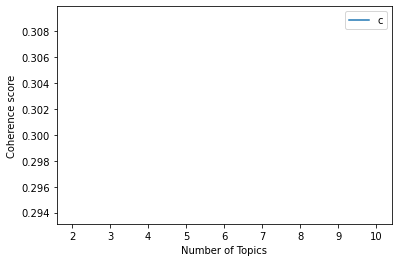

In [17]:
x = range(2, 12, 1)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#REVIEW CLASSIFICATION#

In [54]:
path='/content/drive/My Drive/Recommender/ratings_train.csv'
data1=pandas.read_csv(path)
data1=data1[:4000]

4    1332
3    1116
5     827
2     485
1     240
Name: rating, dtype: int64


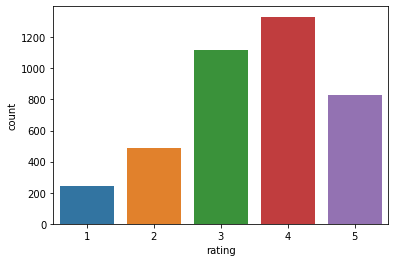

In [55]:
print(data1['rating'].value_counts())
sns.countplot(data1.rating)

In [56]:
data['Cleaned Text'] = data['essay'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['Cleaned Text'] = data['Cleaned Text'].str.replace('[^\w\s]','')
stop = stopwords.words('english')
data['Cleaned Text'] = data['Cleaned Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [57]:
Tfidfvector = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
Tfidfvector.fit(data['essay'])
x_values = Tfidfvector.transform(data['essay'])
encoder = LabelEncoder()
y_values = encoder.fit_transform(data1['rating'])

In [58]:
X_train, x_test, y_train, y_test = model_selection.train_test_split(x_values, y_values, test_size=0.2)

##SVM##

In [59]:
svm = svm.SVC(kernel='linear')
svm.fit(X_train, y_train)
predicted = svm.predict(x_test)
print("Accuracy score is {0}".format(accuracy_score(y_test, predicted)))
report = classification_report(y_test, predicted, output_dict=True)
report

Accuracy score is 0.30625


{'0': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 52},
 '1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 106},
 '2': {'f1-score': 0.3216494845360825,
  'precision': 0.3046875,
  'recall': 0.3406113537117904,
  'support': 229},
 '3': {'f1-score': 0.414535666218035,
  'precision': 0.3228511530398323,
  'recall': 0.5789473684210527,
  'support': 266},
 '4': {'f1-score': 0.12322274881516587,
  'precision': 0.203125,
  'recall': 0.08843537414965986,
  'support': 147},
 'accuracy': 0.30625,
 'macro avg': {'f1-score': 0.17188157991385666,
  'precision': 0.16613273060796646,
  'recall': 0.20159881925650058,
  'support': 800},
 'weighted avg': {'f1-score': 0.252547454060737,
  'precision': 0.2318890240107442,
  'recall': 0.30625,
  'support': 800}}

##Naive Bayes##

In [61]:
n = naive_bayes.MultinomialNB()
n.fit(X_train, y_train)
predicted = n.predict(x_test)
print("Accuracy score is {0}".format(accuracy_score(y_test, predicted)))
report = classification_report(y_test, predicted, output_dict=True)
report

Accuracy score is 0.32875


{'0': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 52},
 '1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 106},
 '2': {'f1-score': 0.17230769230769227,
  'precision': 0.2916666666666667,
  'recall': 0.1222707423580786,
  'support': 229},
 '3': {'f1-score': 0.4849740932642487,
  'precision': 0.33476394849785407,
  'recall': 0.8796992481203008,
  'support': 266},
 '4': {'f1-score': 0.013157894736842105,
  'precision': 0.2,
  'recall': 0.006802721088435374,
  'support': 147},
 'accuracy': 0.32875,
 'macro avg': {'f1-score': 0.13408793606175662,
  'precision': 0.16528612303290413,
  'recall': 0.20175454231336296,
  'support': 800},
 'weighted avg': {'f1-score': 0.21299472609133432,
  'precision': 0.23154859620886983,
  'recall': 0.32875,
  'support': 800}}

#REGRESSION#

In [41]:
p=pandas.DataFrame({'texts':data['clean_subcategories'],'t':data['teacher_number_of_previously_posted_projects'],'p': data['project_is_approved'],'price':data['price']})
p.head()

,texts,t,p,price
0,appliedsciences health_lifescience,53,1,725.05
1,specialneeds,4,1,213.03
2,literacy,10,1,329.00
3,earlydevelopment,2,1,481.04
4,literacy,2,1,17.74


In [42]:
l = LabelEncoder()
l.fit(list(p['texts'].values))
p['ctexts'] = l.transform(list(p['texts'].values))

In [43]:
x_values = p[[ 't', 'p', 'ctexts']]
y_values = p['price']
x_train,x_test, y_train, y_test=train_test_split(x_values, y_values,test_size=0.2)

In [44]:
model = XGBRegressor(random_state=96)
model.fit(x_train, y_train)
model.score(x_test, y_test),model.score(x_train, y_train)

[07:38:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(0.011806875234113945, 0.11787206402517314)

In [47]:
parameter_grid = {
    'max_depth' : [4,5,6,7],
    'max_features': [0.5, 0.7]
    }

gridsearch = GridSearchCV(estimator=model, param_grid=parameter_grid, scoring='neg_mean_squared_error', cv=5)
gridsearch.fit(x_train, y_train)
gridsearch.best_params_

[07:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

{'max_depth': 4, 'max_features': 0.5}

In [48]:
modelxg = XGBRegressor(random_state=96,max_depth=4, max_features= 0.5)
modelxg.fit(x_train, y_train)
modelxg.score(x_test, y_test),modelxg.score(x_train, y_train)

[07:38:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(-0.01158859478137142, 0.21075665432445126)

In [34]:
X_train, X_test, y1_train, y1_test = train_test_split(x_values, y_values,test_size=0.2)
n_features = X_train.shape[1]
# creating model
inputs = Input(shape = (n_features,))
dense1 = Dense(1024, activation = 'relu')(inputs)
dense2 = Dense(1000, activation = 'relu')(dense1)
dense3 = Dense(956, activation = 'relu')(dense2)
dense4 = Dense(752, activation = 'relu')(dense3)
dense5 = Dense(652, activation = 'relu')(dense4)
dense6 = Dense(512, activation = 'relu')(dense5)
dense7 = Dense(500, activation = 'relu')(dense6)
dense8 = Dense(300, activation = 'relu')(dense7)
dense9 = Dense(128, activation = 'relu')(dense8)
dense10 = Dense(32, activation = 'relu')(dense9)
 
# create output
output = Dense(1, activation = 'relu')(dense9)
 
# use output from dense layer 3 to create autoencder output
up_dense1 = Dense(128, activation = 'relu')(dense3)
up_dense2 = Dense(512, activation = 'relu')(up_dense1)
decoded_outputs = Dense(n_features)(up_dense2)
model = Model(inputs, [output,decoded_outputs])
model.summary()
m = 25
n_epoch = 25
model.compile(optimizer='adam', loss=['binary_crossentropy', 'mse'], metrics = ['accuracy'])
model.fit(X_train,[y1_train, X_train], epochs=n_epoch, batch_size=m, shuffle=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         4096        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1000)         1025000     dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 956)          956956      dense_1[0][0]                    
______________________________________________________________________________________________

In [35]:
_,_,_,_,acc=model.evaluate(X_test,[y1_test, X_test], batch_size=m,verbose=0)
print('Test Accuracy: %.3f' % acc)

Test Accuracy: 0.989


In [49]:
from sklearn.linear_model import LinearRegression
reg_model = LinearRegression()
reg_model.fit(x_values, y_values)
predicted = reg_model.predict(x_values)
pandas.DataFrame({'Predicted House Price Values': predicted})

,Predicted House Price Values
0,515.601379
1,302.536987
2,240.124069
3,260.532135
4,266.565521
...,...
3995,307.286591
3996,545.843933
3997,199.798279
3998,239.393875
